In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
import tensorflow as tf
import math
from sklearn.metrics import mean_squared_error

In [34]:
data = pd.read_csv('Stock.csv')

In [35]:
data.head()

,Unnamed: 0,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,0,AAPL,2015-05-27 00:00:00+00:00,132.045,132.260,130.05,130.34,45833246,121.682558,121.880685,119.844118,120.111360,45833246,0.0,1.0
1,1,AAPL,2015-05-28 00:00:00+00:00,131.780,131.950,131.10,131.86,30733309,121.438354,121.595013,120.811718,121.512076,30733309,0.0,1.0
2,2,AAPL,2015-05-29 00:00:00+00:00,130.280,131.450,129.90,131.23,50884452,120.056069,121.134251,119.705890,120.931516,50884452,0.0,1.0
3,3,AAPL,2015-06-01 00:00:00+00:00,130.535,131.390,130.05,131.20,32112797,120.291057,121.078960,119.844118,120.903870,32112797,0.0,1.0
4,4,AAPL,2015-06-02 00:00:00+00:00,129.960,130.655,129.32,129.86,33667627,119.761181,120.401640,119.171406,119.669029,33667627,0.0,1.0


In [36]:
data1 = data.reset_index()['close']

In [37]:
data1

0       132.045
1       131.780
2       130.280
3       130.535
4       129.960
         ...   
1253    314.960
1254    313.140
1255    319.230
1256    316.850
1257    318.890
Name: close, Length: 1258, dtype: float64

In [38]:
data1.shape

(1258,)

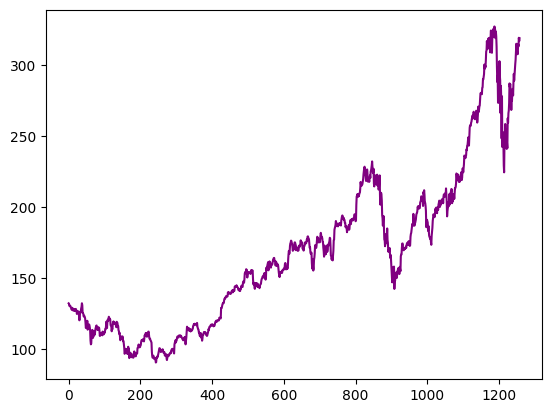

In [39]:
plt.plot(data1 , color = "purple")

In [40]:
scaler = MinMaxScaler(feature_range=(0,1))

In [41]:
data1 = scaler.fit_transform(np.array(data1).reshape(-1,1))

In [42]:
data1

array([[0.17607447],
       [0.17495567],
       [0.16862282],
       ...,
       [0.96635143],
       [0.9563033 ],
       [0.96491598]])

In [43]:
# splitting the dataset into train and test split :
training_size = int(len(data1)*0.65)

In [44]:
test_size = len(data1) - training_size

In [45]:
train_data,test_data = data1[0:training_size,:],data1[training_size:len(data1),:1]

In [46]:
len(train_data)

817

In [47]:
len(test_data)

441

In [48]:
# converting the array values into a dataset matrix :
def create_dataset(dataset, time_step = 1):
    dataX , dataY = [], []
    for i in range(len(dataset) - time_step - 1 ):
        a = dataset[i:(i + time_step), 0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [49]:
time_step = 100

In [50]:
X_train, y_train = create_dataset(train_data, time_step)

X_test, y_test = create_dataset(test_data, time_step)

In [51]:
X_train.shape

(716, 100)

In [52]:
X_train, y_train = create_dataset(train_data, time_step)

X_test, y_test = create_dataset(test_data, time_step)

In [53]:
X_train.shape

(716, 100)

In [54]:
y_train.shape

(716,)

In [55]:
X_test.shape

(340, 100)

In [56]:
y_test.shape

(340,)

In [57]:
# reshape the input to be in [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)

In [58]:
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [59]:
model=Sequential()

In [60]:
model.add(LSTM(50,return_sequences = True,input_shape = (100,1)))
model.add(LSTM(50,return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer = 'adam')

In [61]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 50)           10400     
                                                                 
 lstm_4 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dense_1 (Dense)             (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [62]:
# prediction and performance metrics:
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

11/11 [==============================] - 0s 34ms/step


In [63]:
# Back to original form :
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

In [64]:
# RMSE performance metrics (Training dataset):
math.sqrt(mean_squared_error(y_train,train_predict))

87.71849990672266

In [65]:
# RMSE performance metrics (Test dataset):
math.sqrt(mean_squared_error(y_test,test_predict))

82.58362183308463

In [66]:
# shifting train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(data1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shifting test predictions for plotting
testPredictPlot = np.empty_like(data1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(data1)-1, :] = test_predict

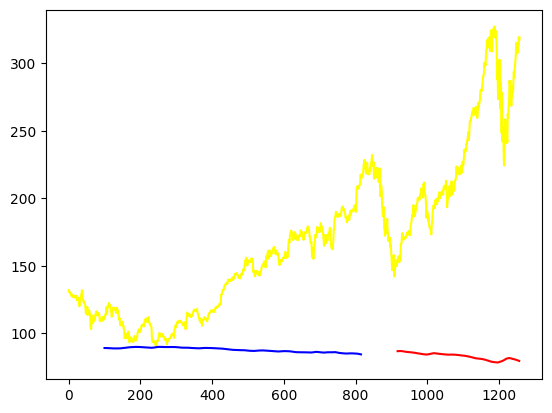

In [67]:
# ploting baseline and predictions
plt.plot(scaler.inverse_transform(data1) , color = "yellow")
plt.plot(trainPredictPlot , color = "blue") # train predict data
plt.plot(testPredictPlot  , color = "red") # test predict data
plt.show()

In [68]:
# previous 100 days:
x_input = test_data[341:].reshape(1,-1)
x_input.shape

(1, 100)

In [69]:
temp_input = list(x_input)

In [70]:
temp_input = temp_input[0].tolist()

In [74]:
# demonstrate prediction for next 30 days
lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input = np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        # print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[-0.04579764]
101
1 day input [ 0.8866419   0.87431394  0.88431985  0.87836697  0.8986321   0.92582116
  0.92877649  0.95676771  0.93869797  0.93304061  0.94950604  0.96424048
  0.95512117  0.95989192  0.96635143  0.96246728  0.92295027  0.9598497
  0.98792536  0.98594106  0.92531453  0.92172591  0.96474711  0.97572406
  0.99159841  0.96972895  0.97614625  0.96795575  1.          0.99016297
  0.99050072  0.96538039  0.98488559  0.97086887  0.94026007  0.87748037
  0.83483915  0.85413324  0.77336823  0.77269273  0.88014017  0.84007431
  0.89673225  0.85527316  0.83884995  0.74233725  0.82327113  0.78143207
  0.6665963   0.7921557   0.64118044  0.68614371  0.66001013  0.65203074
  0.58642236  0.56586169  0.66089673  0.65515494  0.70970193  0.66452757
  0.69437642  0.69218104  0.63569197  0.65266402  0.63780292  0.7267162
  0.71388162  0.74191506  0.75002111  0.77222832  0.83049059  0.8194292
  0.8289707   0.8125475   0.78776492  0.75162543  0.78426074  0.77974331
  0.81326522  0.8141096 

In [75]:
day_new=np.arange(1,101)

In [76]:
day_pred=np.arange(101,131)

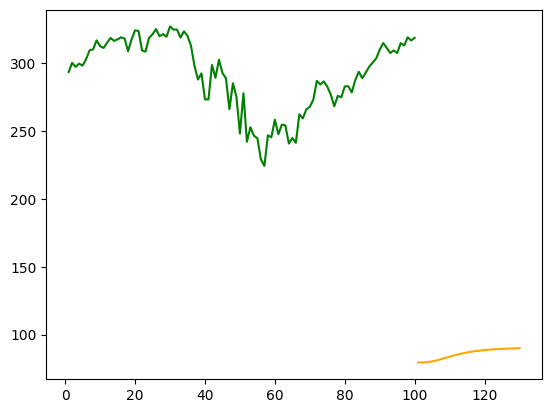

In [77]:
plt.plot(day_new,scaler.inverse_transform(data1[1158:]) , color="green")
plt.plot(day_pred,scaler.inverse_transform(lst_output) , color = "orange")

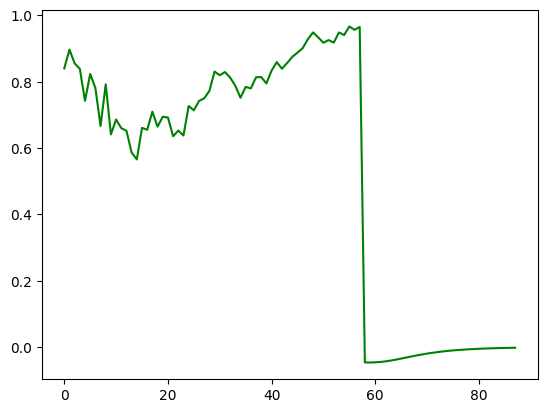

In [78]:
data3 = data1.tolist()
data3.extend(lst_output)
plt.plot(data3[1200:] , color = "green")